In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/burn-data-seg/burn_intensity_data/train_images/quarry_ca3806111999220230909_0224_0000_HLS.tiff
/kaggle/input/burn-data-seg/burn_intensity_data/train_images/mountain_az_0224_0224_HLS.tiff
/kaggle/input/burn-data-seg/burn_intensity_data/train_images/or4265012082720180815_0000_0448_HLS.tiff
/kaggle/input/burn-data-seg/burn_intensity_data/train_images/rabbit_ca3671811888320230930_0000_0000_HLS.tiff
/kaggle/input/burn-data-seg/burn_intensity_data/train_images/dixie_id4558511544420210705_0000_0224_HLS.tiff
/kaggle/input/burn-data-seg/burn_intensity_data/train_images/nm3372410853720180522_0000_0448_HLS.tiff
/kaggle/input/burn-data-seg/burn_intensity_data/train_images/quarry_ca3806111999220230909_0000_0000_HLS.tiff
/kaggle/input/burn-data-seg/burn_intensity_data/train_images/grizzlycreek_0224_0224_HLS.tiff
/kaggle/input/burn-data-seg/burn_intensity_data/train_images/dixie_id4558511544420210705_0000_0000_HLS.tiff
/kaggle/input/burn-data-seg/burn_intensity_data/train_images/indian_

In [ ]:
!pip install gdal
!pip install terratorch
!pip install rasterio
!pip install gradio_client

Getting the actual labels of test images by converting the grade values of 1 to 4 as just 1 and rest as 0. This needs to be later used as ground truth for burn scar baseline

In [23]:
import os
import rasterio
import numpy as np
from tqdm import tqdm

# Paths to the label folders
label_folders = {
  
    "test": "/kaggle/input/burn-data-seg/burn_intensity_data/test_labels"
}

# Output base folder for binary masks
output_base_folder = "/kaggle/working/binary_masks"
os.makedirs(output_base_folder, exist_ok=True)

# Process each label folder
for split, folder_path in label_folders.items():
    output_folder = os.path.join(output_base_folder, split)
    os.makedirs(output_folder, exist_ok=True)
    
    print(f"Processing {split} labels...")
    
    for mask_file in tqdm(os.listdir(folder_path), desc=f"Processing {split} masks"):
        input_path = os.path.join(folder_path, mask_file)
        output_path = os.path.join(output_folder, mask_file)
        
        # Open the grading mask using rasterio
        with rasterio.open(input_path) as src:
            grading_mask = src.read(1)  # Read the first band (assuming single-band masks)
            profile = src.profile  # Get the profile (metadata) of the input file

            # Create binary mask: 1 for burn scars (non-zero values), 0 for no burn
            binary_mask = np.where(grading_mask > 0, 1, 0).astype(np.uint8)
            
            # Update the profile for binary mask output
            profile.update(dtype=rasterio.uint8, count=1)
            
            # Save the binary mask
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(binary_mask, 1)

print("All label folders processed and binary masks created.")


Processing test labels...


Processing test masks: 100%|██████████| 30/30 [00:00<00:00, 52.96it/s]

All label folders processed and binary masks created.


Using gradio to call the API of the burn scar model of Prithvi from Hugging face - https://huggingface.co/spaces/ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo


In [ ]:
import os
from gradio_client import Client, handle_file




In [ ]:
from gradio_client import Client, file

# Initialize the client
#removed the token for security
HF_
= "HF_token"
#clinet = Client.duplicate("ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo", hf_token=HF_TOKEN)
client = Client("ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo")

# Replace 'your_tiff_file.tiff' with the path to your local TIFF file
result = client.predict(
    target_image=file("/kaggle/input/burn-data-seg/burn_intensity_data/test_images/beachiecreek_0224_0000_HLS.tiff"),
    
    #target_image=file('/kaggle/working/training/subsetted_512x512_HLS.S30.T10SEH.2018245.v1.4_merged.tif'),
    api_name="/partial"
)

print(result)

Loaded as API: https://ibm-nasa-geospatial-prithvi-100m-burn-scars-demo.hf.space ✔
('/tmp/gradio/22df09300f16418901dfc9c9da46832bf8a5c9bbbf671640a8ceecfe58deb8d0/image.webp', '/tmp/gradio/87af918ff8d7367a6186fe31306de02ff29d206f01f6ba357eaca61a3e05f1a7/image.webp')


In [ ]:
import os
from gradio_client import Client, file

# Initialize the client
client = Client("ibm-nasa-geospatial/Prithvi-100M-Burn-scars-demo")

# Path to the folder containing TIFF files
folder_path = "/kaggle/input/burn-data-seg/burn_intensity_data/test_images"

# List to store results
results = []

# Loop through all TIFF files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif") or filename.endswith(".tiff"):  # Check for TIFF files
        file_path = os.path.join(folder_path, filename)
        print(f"Processing file: {file_path}")

        # Get the result for the current TIFF file
        result = client.predict(
            target_image=file(file_path),
            api_name="/partial"
        )
        
        # Append the result along with the filename to the results list
        results.append({"filename": filename, "result": result[1]})

        print(f"Result for {filename}: {result}")




Loaded as API: https://ibm-nasa-geospatial-prithvi-100m-burn-scars-demo.hf.space ✔
Processing file: /kaggle/input/burn-data-seg/burn_intensity_data/test_images/or4265012082720180815_0000_0672_HLS.tiff
Result for or4265012082720180815_0000_0672_HLS.tiff: ('/tmp/gradio/caff033e90fc406fde4f5b80c82612cdc1aa592805cee2162496f99536f6e2b4/image.webp', '/tmp/gradio/caff033e90fc406fde4f5b80c82612cdc1aa592805cee2162496f99536f6e2b4/image.webp')
Processing file: /kaggle/input/burn-data-seg/burn_intensity_data/test_images/badger_id_2020_0448_0224_HLS.tiff
Result for badger_id_2020_0448_0224_HLS.tiff: ('/tmp/gradio/22df09300f16418901dfc9c9da46832bf8a5c9bbbf671640a8ceecfe58deb8d0/image.webp', '/tmp/gradio/70e12e705cb9c749814c644a9056374b188d5bd6ccd49b1d4df29f766bb52890/image.webp')
Processing file: /kaggle/input/burn-data-seg/burn_intensity_data/test_images/beachiecreek_0224_0672_HLS.tiff
Result for beachiecreek_0224_0672_HLS.tiff: ('/tmp/gradio/22df09300f16418901dfc9c9da46832bf8a5c9bbbf671640a8ceecfe

In [16]:
#Optionally, save results to a file
output_file = "/kaggle/working/burn_scar_results.txt"
with open(output_file, "w") as f:
    for entry in results:
        f.write(f"Filename: {entry['filename']}\nResult: {entry['result']}\n\n")

print(f"All results saved to {output_file}")


All results saved to /kaggle/working/burn_scar_results.txt


In [20]:
results

[{'filename': 'or4265012082720180815_0000_0672_HLS.tiff',
  'result': '/tmp/gradio/caff033e90fc406fde4f5b80c82612cdc1aa592805cee2162496f99536f6e2b4/image.webp'},
 {'filename': 'badger_id_2020_0448_0224_HLS.tiff',
  'result': '/tmp/gradio/70e12e705cb9c749814c644a9056374b188d5bd6ccd49b1d4df29f766bb52890/image.webp'},
 {'filename': 'beachiecreek_0224_0672_HLS.tiff',
  'result': '/tmp/gradio/edbf342ca73cb3c683ab10b313c936f8b7e59543032c05fce9bc53da29f1fd78/image.webp'},
 {'filename': 'green_ridge_0000_0448_HLS.tiff',
  'result': '/tmp/gradio/1346dab2e353c0428ce317104a25943d36defd7613c0acc2beb75595954b6e2b/image.webp'},
 {'filename': 'indian_ridge_id4578511471120220708_0224_0672_HLS.tiff',
  'result': '/tmp/gradio/0c26b810be4070392153b2d2237284821d04b8fd143fe99b60db3a588d992c67/image.webp'},
 {'filename': 'cub_nm3331510856220200628_0000_0224_HLS.tiff',
  'result': '/tmp/gradio/6f7349fda923d88e6aac5d0b9402cea9dd9112ff50f8ec17e059ad18d6c04b62/image.webp'},
 {'filename': 'beachiecreek_0000_0224

Put all the webp files from temporary storage, rename them with their actual filenames and put it into a directory

In [25]:
import os
import shutil

# Results list (example)


# Folder where WebP files will be saved
output_folder = "/kaggle/working/output_webp_files"

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Loop through the results and copy each WebP file to the folder with the new name
for item in results:
    source_path = item['result']  # Source WebP file path
    original_filename = os.path.basename(item['filename'])  # Get original filename
    prefix = os.path.splitext(original_filename)[0]  # Remove ".tiff" to get the prefix
    new_filename = f"{prefix}.webp"  # Create the new filename with .webp extension
    destination_path = os.path.join(output_folder, new_filename)

    # Copy and rename the WebP file
    shutil.copy(source_path, destination_path)
    print(f"Copied and renamed {source_path} to {destination_path}")

print(f"All WebP files have been saved and renamed in {output_folder}")


Copied and renamed /tmp/gradio/caff033e90fc406fde4f5b80c82612cdc1aa592805cee2162496f99536f6e2b4/image.webp to /kaggle/working/output_webp_files/or4265012082720180815_0000_0672_HLS.webp
Copied and renamed /tmp/gradio/70e12e705cb9c749814c644a9056374b188d5bd6ccd49b1d4df29f766bb52890/image.webp to /kaggle/working/output_webp_files/badger_id_2020_0448_0224_HLS.webp
Copied and renamed /tmp/gradio/edbf342ca73cb3c683ab10b313c936f8b7e59543032c05fce9bc53da29f1fd78/image.webp to /kaggle/working/output_webp_files/beachiecreek_0224_0672_HLS.webp
Copied and renamed /tmp/gradio/1346dab2e353c0428ce317104a25943d36defd7613c0acc2beb75595954b6e2b/image.webp to /kaggle/working/output_webp_files/green_ridge_0000_0448_HLS.webp
Copied and renamed /tmp/gradio/0c26b810be4070392153b2d2237284821d04b8fd143fe99b60db3a588d992c67/image.webp to /kaggle/working/output_webp_files/indian_ridge_id4578511471120220708_0224_0672_HLS.webp
Copied and renamed /tmp/gradio/6f7349fda923d88e6aac5d0b9402cea9dd9112ff50f8ec17e059ad18d

In [26]:
import os

# Define the folder and zip file names
folder_to_zip = "/kaggle/working/output_webp_files"
output_zip = "/kaggle/working/burn_scar_results_test.zip"

# Create the zip file
os.system(f"zip -r {output_zip} {folder_to_zip}")
print(f"Created zip file: {output_zip}")


Created zip file: /kaggle/working/burn_scar_results_test.zip


In [ ]:
!pip install rasterio

In [33]:
import os
import numpy as np
import torch
from PIL import Image
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryJaccardIndex

# Paths to the folders
ground_truth_folder = "/kaggle/input/ground-truth-mask-burn-seg/kaggle/working/binary_masks/test"
evaluated_folder = "/kaggle/input/evaluated-mask-burn-seg/kaggle/working/output_webp_files"

# Initialize metrics
accuracy_metric = BinaryAccuracy()
f1_score_metric = BinaryF1Score()
jaccard_index_metric = BinaryJaccardIndex()

# Initialize lists to store metrics for all files
accuracies = []
f1_scores = []
jaccard_indices = []

# Get list of ground truth files
ground_truth_files = sorted(os.listdir(ground_truth_folder))

# Loop through ground truth files and find corresponding evaluated files
for gt_file in ground_truth_files:
    # Extract the common prefix by removing the last suffix and extension
    gt_prefix = "_".join(gt_file.split("_")[:-1])
    
    # Find the corresponding evaluated file by matching the prefix
    matching_files = [f for f in os.listdir(evaluated_folder) if f.startswith(gt_prefix)]
    
    if not matching_files:
        print(f"No matching evaluated file found for {gt_file}")
        continue  # Skip if no matching file is found
    
    evaluated_file = matching_files[0]  # Assuming only one match exists

    # Load ground truth and evaluated mask
    gt_path = os.path.join(ground_truth_folder, gt_file)
    eval_path = os.path.join(evaluated_folder, evaluated_file)

    ground_truth = np.array(Image.open(gt_path))
    evaluated = np.array(Image.open(eval_path).convert("L"))  # Convert webp to grayscale

    # Ensure both images have the same shape
    if ground_truth.shape != evaluated.shape:
        print(f"Shape mismatch for {gt_file} and {evaluated_file}, skipping.")
        continue

    # Apply binary thresholding to evaluated mask (all values > 0 become 1)
    evaluated_binary = (evaluated > 0).astype(int)
    # fig, ax = plt.subplots(1, 1, figsize=(16, 4))

    # ax.imshow(evaluated_binary, cmap="gray")
    # # Convert to PyTorch tensors
    ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.int)
    evaluated_tensor = torch.tensor(evaluated_binary, dtype=torch.int)
    
    # Compute metrics
    accuracy = accuracy_metric(evaluated_tensor, ground_truth_tensor)
    f1_score = f1_score_metric(evaluated_tensor, ground_truth_tensor)
    jaccard_index = jaccard_index_metric(evaluated_tensor, ground_truth_tensor)

    # Store metrics
    accuracies.append(accuracy.item())
    f1_scores.append(f1_score.item())
    jaccard_indices.append(jaccard_index.item())

    # Print metrics for the current file
    print(f"File: {gt_file}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1_score:.4f}")
    print(f"  Jaccard Index (IoU): {jaccard_index:.4f}")
    print("-" * 40)

# Compute and print overall metrics (average across all files)
mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
mean_jaccard_index = np.mean(jaccard_indices)

print(f"Overall Metrics:")
print(f"  Mean Accuracy: {mean_accuracy:.4f}")
print(f"  Mean F1 Score: {mean_f1_score:.4f}")
print(f"  Mean Jaccard Index (IoU): {mean_jaccard_index:.4f}")


File: badger_id_2020_0224_0000_BS.tiff
  Accuracy: 0.2274
  F1 Score: 0.0028
  Jaccard Index (IoU): 0.0014
----------------------------------------
File: badger_id_2020_0224_0224_BS.tiff
  Accuracy: 0.4141
  F1 Score: 0.2509
  Jaccard Index (IoU): 0.1434
----------------------------------------
File: badger_id_2020_0448_0224_BS.tiff
  Accuracy: 0.2997
  F1 Score: 0.3292
  Jaccard Index (IoU): 0.1970
----------------------------------------
File: beachiecreek_0000_0224_BS.tiff
  Accuracy: 0.7170
  F1 Score: 0.8321
  Jaccard Index (IoU): 0.7125
----------------------------------------
File: beachiecreek_0224_0000_BS.tiff
  Accuracy: 0.0022
  F1 Score: 0.0000
  Jaccard Index (IoU): 0.0000
----------------------------------------
File: beachiecreek_0224_0672_BS.tiff
  Accuracy: 0.7452
  F1 Score: 0.8540
  Jaccard Index (IoU): 0.7452
----------------------------------------
File: beachiecreek_0672_0000_BS.tiff
  Accuracy: 0.4117
  F1 Score: 0.5672
  Jaccard Index (IoU): 0.3958
-------------

In [35]:
import os
import numpy as np
import torch
from PIL import Image
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryJaccardIndex
from torch.nn import BCEWithLogitsLoss
from collections.abc import Callable

# Define a callable class for computing loss
class BinaryCrossEntropyLoss(Callable):
    def __init__(self):
        self.loss_fn = BCEWithLogitsLoss()  # Using BCE with logits for stability

    def __call__(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Ensure predictions are in float format (required for BCEWithLogitsLoss)
        preds = preds.float()
        targets = targets.float()
        return self.loss_fn(preds, targets)


# Paths to the folders
ground_truth_folder = "/kaggle/input/ground-truth-mask-burn-seg/kaggle/working/binary_masks/test"
evaluated_folder = "/kaggle/input/evaluated-mask-burn-seg/kaggle/working/output_webp_files"

# Initialize metrics
accuracy_metric = BinaryAccuracy()
f1_score_metric = BinaryF1Score()
jaccard_index_metric = BinaryJaccardIndex()

# Initialize loss function
loss_fn = BinaryCrossEntropyLoss()

# Initialize lists to store metrics and loss for all files
accuracies = []
f1_scores = []
jaccard_indices = []
losses = []

# Get list of ground truth files
ground_truth_files = sorted(os.listdir(ground_truth_folder))

# Loop through ground truth files and find corresponding evaluated files
for gt_file in ground_truth_files:
    # Extract the common prefix by removing the last suffix and extension
    gt_prefix = "_".join(gt_file.split("_")[:-1])
    
    # Find the corresponding evaluated file by matching the prefix
    matching_files = [f for f in os.listdir(evaluated_folder) if f.startswith(gt_prefix)]
    
    if not matching_files:
        print(f"No matching evaluated file found for {gt_file}")
        continue  # Skip if no matching file is found
    
    evaluated_file = matching_files[0]  # Assuming only one match exists

    # Load ground truth and evaluated mask
    gt_path = os.path.join(ground_truth_folder, gt_file)
    eval_path = os.path.join(evaluated_folder, evaluated_file)

    ground_truth = np.array(Image.open(gt_path))
    evaluated = np.array(Image.open(eval_path).convert("L"))  # Convert webp to grayscale

    # Ensure both images have the same shape
    if ground_truth.shape != evaluated.shape:
        print(f"Shape mismatch for {gt_file} and {evaluated_file}, skipping.")
        continue

    # Apply binary thresholding to evaluated mask (all values > 0 become 1)
    evaluated_binary = (evaluated > 0).astype(int)
    ax.imshow(evaluated_binary, cmap="gray")
    
    # Convert to PyTorch tensors
    ground_truth_tensor = torch.tensor(ground_truth, dtype=torch.int)
    evaluated_tensor = torch.tensor(evaluated_binary, dtype=torch.int)

    # Compute metrics
    accuracy = accuracy_metric(evaluated_tensor, ground_truth_tensor)
    f1_score = f1_score_metric(evaluated_tensor, ground_truth_tensor)
    jaccard_index = jaccard_index_metric(evaluated_tensor, ground_truth_tensor)
    
    # Compute loss
    loss = loss_fn(evaluated_tensor, ground_truth_tensor)

    # Store metrics and loss
    accuracies.append(accuracy.item())
    f1_scores.append(f1_score.item())
    jaccard_indices.append(jaccard_index.item())
    losses.append(loss.item())

    # Print metrics and loss for the current file
    print(f"File: {gt_file}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Score: {f1_score:.4f}")
    print(f"  Jaccard Index (IoU): {jaccard_index:.4f}")
    print(f"  Loss: {loss:.4f}")
    print("-" * 40)

# Compute and print overall metrics (average across all files)
mean_accuracy = np.mean(accuracies)
mean_f1_score = np.mean(f1_scores)
mean_jaccard_index = np.mean(jaccard_indices)
mean_loss = np.mean(losses)

print(f"Overall Metrics:")
print(f"  Mean Accuracy: {mean_accuracy:.4f}")
print(f"  Mean F1 Score: {mean_f1_score:.4f}")
print(f"  Mean Jaccard Index (IoU): {mean_jaccard_index:.4f}")
print(f"  Mean Loss: {mean_loss:.4f}")

print(len(accuracies))

File: badger_id_2020_0224_0000_BS.tiff
  Accuracy: 0.2274
  F1 Score: 0.0028
  Jaccard Index (IoU): 0.0014
  Loss: 0.6927
----------------------------------------
File: badger_id_2020_0224_0224_BS.tiff
  Accuracy: 0.4141
  F1 Score: 0.2509
  Jaccard Index (IoU): 0.1434
  Loss: 0.7978
----------------------------------------
File: badger_id_2020_0448_0224_BS.tiff
  Accuracy: 0.2997
  F1 Score: 0.3292
  Jaccard Index (IoU): 0.1970
  Loss: 0.7715
----------------------------------------
File: beachiecreek_0000_0224_BS.tiff
  Accuracy: 0.7170
  F1 Score: 0.8321
  Jaccard Index (IoU): 0.7125
  Loss: 0.5679
----------------------------------------
File: beachiecreek_0224_0000_BS.tiff
  Accuracy: 0.0022
  F1 Score: 0.0000
  Jaccard Index (IoU): 0.0000
  Loss: 1.3119
----------------------------------------
File: beachiecreek_0224_0672_BS.tiff
  Accuracy: 0.7452
  F1 Score: 0.8540
  Jaccard Index (IoU): 0.7452
  Loss: 0.4758
----------------------------------------
File: beachiecreek_0672_0000

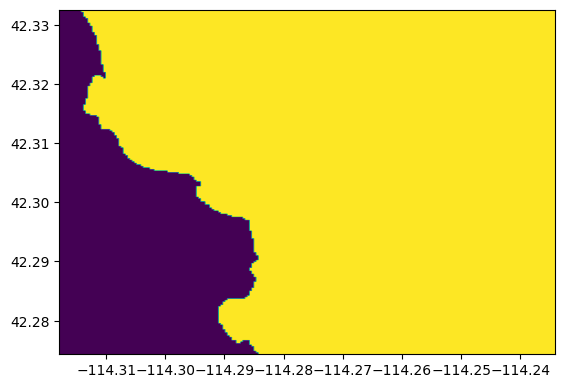

[0 1]


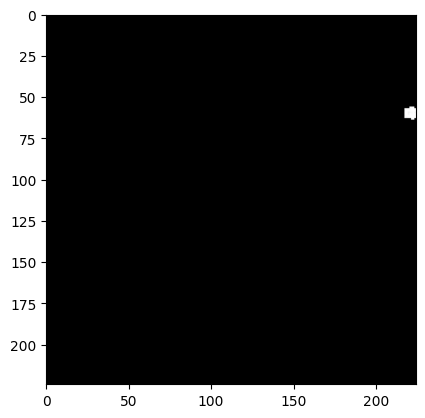

[  0   1   2   3   5 242 245 246 247 248 249 250 252 253 254 255]


In [15]:
import rasterio
from rasterio.plot import show

# Paths to the images returned by Gradio
path1 = "/tmp/gradio/8accdf490a0ab5ec6c90746bce3861a28727bcd05763e10b11927487546f9323/image.webp"
path2 = "/tmp/gradio/87af918ff8d7367a6186fe31306de02ff29d206f01f6ba357eaca61a3e05f1a7/image.webp"
path3 = '/kaggle/input/evaluated-mask-burn-seg/kaggle/working/output_webp_files/badger_id_2020_0224_0000_HLS.webp'
path4 = '/kaggle/input/ground-truth-mask-burn-seg/kaggle/working/binary_masks/test/badger_id_2020_0224_0000_BS.tiff'
# Open the first image
with rasterio.open(path4) as src:
    data = src.read(1)
    show(src)  # Display the image
    print( np.unique(data))


with rasterio.open(path3) as src:
    data = src.read(1)
    show(src)  # Display the image
    print( np.unique(data))

View the binary mask of the predicted output by burn scar baseline

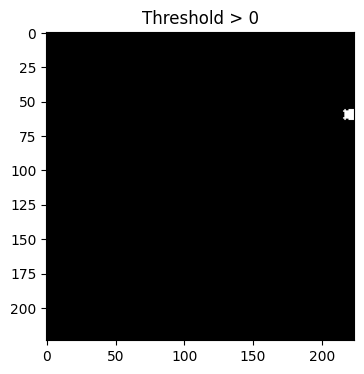

[0 1]


In [32]:
import numpy as np
from skimage import filters
from PIL import Image
import matplotlib.pyplot as plt

# Load the grayscale image
image = np.array(Image.open("/kaggle/input/evaluated-mask-burn-seg/kaggle/working/output_webp_files/badger_id_2020_0224_0000_HLS.webp").convert("L"))

# Apply different thresholds

binary_0 = (image > 0).astype(int)      # Threshold at > 0

# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

ax.imshow(binary_0, cmap="gray")
ax.set_title("Threshold > 0")
plt.show()

print( np.unique(binary_0))
